# Complete workflow to get info from GIS tools for hydrological modelling

Here we use birdy's WPS client to perform a catchment delineation, use the delineation to extract physical properties and prepare data for hydrological modelling, all using the Raven server.

In [5]:
from birdy import WPSClient

from example_data import TESTDATA
import datetime as dt
from urllib.request import urlretrieve
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt

url = "http://localhost:9099/wps"
wps = WPSClient(url, progress=True)

In [6]:
# MANIC: lonlat_coordinate="(-68.724444, 50.646667)"
r_select = wps.shape_selection(location="-75.724444, 44.646667",lakes=True, aggregate_upstream=True)

The `location` parameter identifies the outlet of the watershed, and `aggregate_upstream` determines whether or not we want the service to return all upstream basins. 

In [7]:
# Get JSON Polygons of the delineated catchment
[features, upstream_basins] = r_select.get(asobj=True)
feature = features['features'][0] # TODO: Fix this server-side

Now that we have delineated a catchment, lets find the zonal statistics and other properties of the catchment.

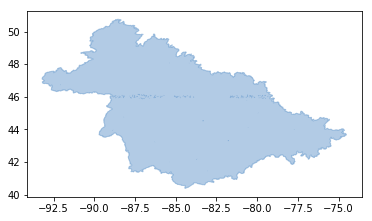

In [8]:
from descartes import PolygonPatch
import matplotlib.pyplot as plt 

BLUE = '#6699cc'
fig = plt.figure() 
ax = fig.gca() 
ax.add_patch(PolygonPatch(feature['geometry'], fc=BLUE, ec=BLUE, alpha=0.5, zorder=2 ))
ax.axis('scaled')
plt.show()


In [9]:
# Here we are using the geojson file created on the server in the last step as the input value to a process 
# computing watershed properties. 
#crs=4326
#projected_crs=32198
[features, upstream_basins] = r_select.get()
resp = wps.shape_properties(shape=features)

In [10]:
[properties]=resp.get(asobj=True)
print(properties)

[{'id': '7120034520', 'COAST': 0, 'DIST_MAIN': 500.1, 'DIST_SINK': 500.1, 'ENDO': 0, 'HYBAS_ID': 7121021261, 'LAKE': 1209, 'NEXT_DOWN': 7120421412, 'NEXT_SINK': 7120034520, 'ORDER': 1, 'PFAF_ID': 725510701200, 'SIDE': 'L', 'SORT': 99271, 'SUB_AREA': 766237.7, 'UP_AREA': 766270.4, 'area': 772095248092.3353, 'centroid': [-84.31996604288439, 45.16993914390546], 'perimeter': 9807568.183716247, 'gravelius': 3.148625180402048}]


# Properties seem off: SUPERFICIE does not seem to coincide with "area". Which is right?

area probably, as long as the projection is ok. In this case, I think the aggregation of upstream basins did not do the sum of the individual basins, so we get the area of the most downstream one. 

## Now, Let's extract Zonal Stats. Again, can't use the asobj=true, so we use False and then I am stuck with the  problem that the results are behind a link I can't seem to access.

Yeah, same problem server-side... 

In [95]:
return_geojson=False



# This should be a GeoServer link to the full raster
raster=TESTDATA['earthenv_dem_90m']

resp = wps.zonal_stats(features, str(raster), select_all_touching=True,return_geojson=return_geojson,)

statistics=resp.get(asobj=False)

In [99]:
print(statistics[0])

http://localhost:9099/outputs/8e6efd40-5034-11e9-9c84-b8ca3a8f5177/input.json


# NEED TO ADD LAND COVER AND SLOPE EXTRACTIONS, BUT THIS IS A GOOD START!